**Using  Pytorch 3D**

In [2]:
# %pip install torch torchvision


In [5]:
import os
import sys
import torch
import subprocess
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
    version_str="".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    !pip install iopath
    if sys.platform.startswith("linux"):
        print("Trying to install wheel for PyTorch3D")
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
        pip_list = !pip freeze
        need_pytorch3d = not any(i.startswith("pytorch3d==") for  i in pip_list)
    if need_pytorch3d:
        print(f"failed to find/install wheel for {version_str}")
if need_pytorch3d:
    print("Installing PyTorch3D from source")
    !pip install ninja
    !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31529 sha256=454712013354828cce3fc51b5c0ed395882fe6918024736643c607f4793c1909
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath
Trying to install wheel for PyTorch3D
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt241/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 150.8 MB/s eta 0:00:00


In [6]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

%matplotlib inline


In [9]:
!wget https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj

--2024-09-27 10:15:52--  https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.51, 3.163.189.14, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156763 (153K) [text/plain]
Saving to: ‘dolphin.obj’

dolphin.obj         100%[===================>] 153.09K  --.-KB/s    in 0.02s   

2024-09-27 10:15:52 (7.09 MB/s) - ‘dolphin.obj’ saved [156763/156763]



In [10]:
obj = "/content/dolphin.obj"

In [11]:
verts, faces, aux = load_obj(obj)

/usr/local/lib/python3.10/dist-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [12]:
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

In [13]:
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

In [14]:
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

In [15]:
src_mesh = ico_sphere(4, device)

In [16]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

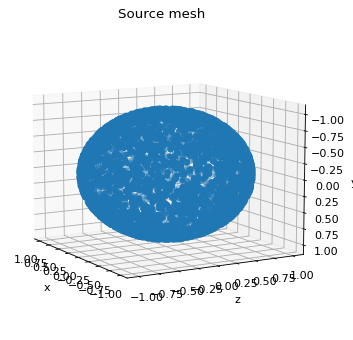

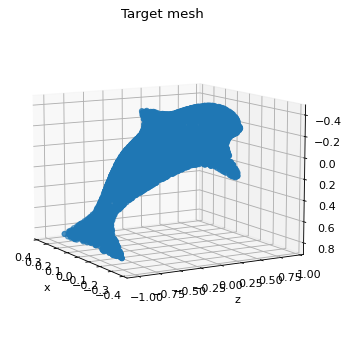

In [17]:
plot_pointcloud(src_mesh, "Source mesh")
plot_pointcloud(trg_mesh, "Target mesh")

In [18]:
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch3d/ops/laplacian_matrices.py:51: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:641.)
  A = torch.sparse.FloatTensor(idx, ones, (V, V))


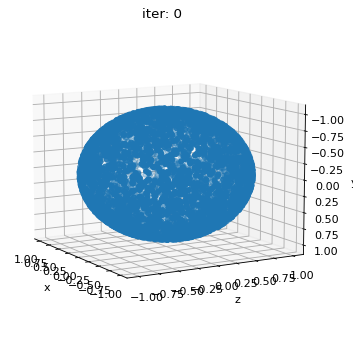

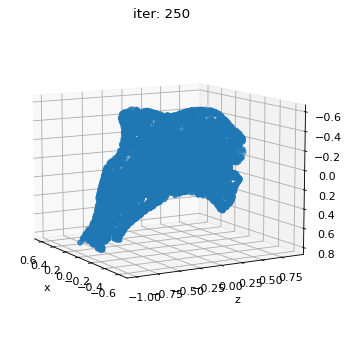

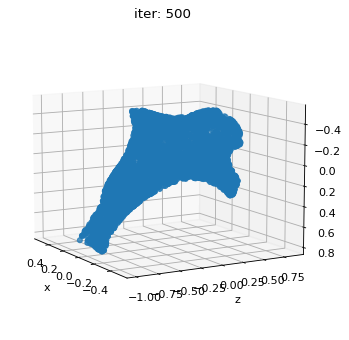

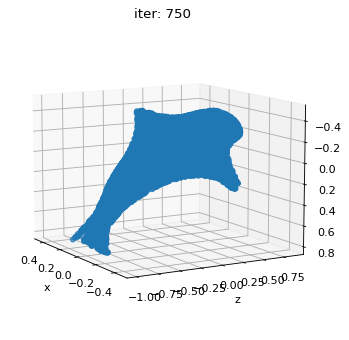

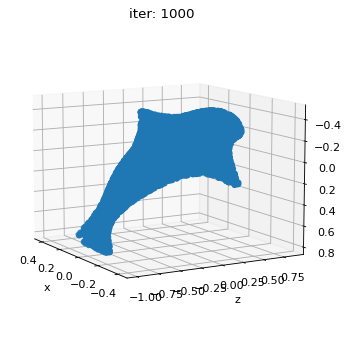

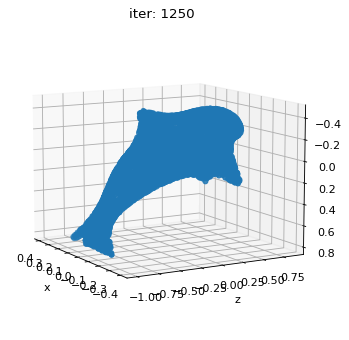

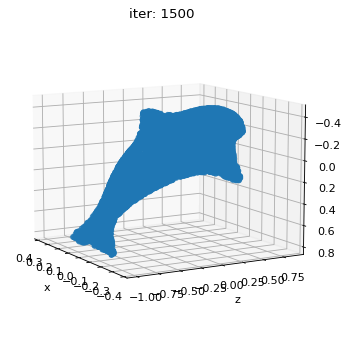

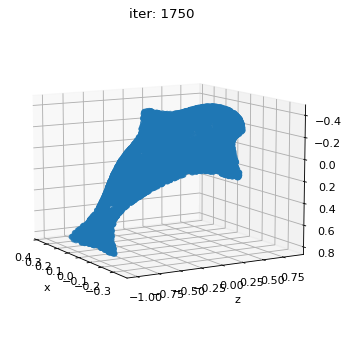

In [20]:

Niter = 2000
w_chamfer = 1.0

w_edge = 1.0

w_normal = 0.01

w_laplacian = 0.1

plot_period = 250
loop = tqdm(range(Niter))

optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []



for i in loop:
    optimizer.zero_grad()


    new_src_mesh= src_mesh.offset_verts(deform_verts)

    sample_target= sample_points_from_meshes(trg_mesh,6000)
    sample_src= sample_points_from_meshes(new_src_mesh,6000)


    loss_chamfer, _ = chamfer_distance(sample_target, sample_src)

    loss_edge = mesh_edge_loss(new_src_mesh)


    loss_normal = mesh_normal_consistency(new_src_mesh)

    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")


    loss = (
        w_chamfer * loss_chamfer
        + w_edge * loss_edge
        + w_normal * loss_normal
        + w_laplacian * loss_laplacian
    )




   # Save the losses for plotting
    chamfer_losses.append(float(loss_chamfer.detach().cpu()))
    edge_losses.append(float(loss_edge.detach().cpu()))
    normal_losses.append(float(loss_normal.detach().cpu()))
    laplacian_losses.append(float(loss_laplacian.detach().cpu()))



    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)

    loss.backward()

    optimizer.step()






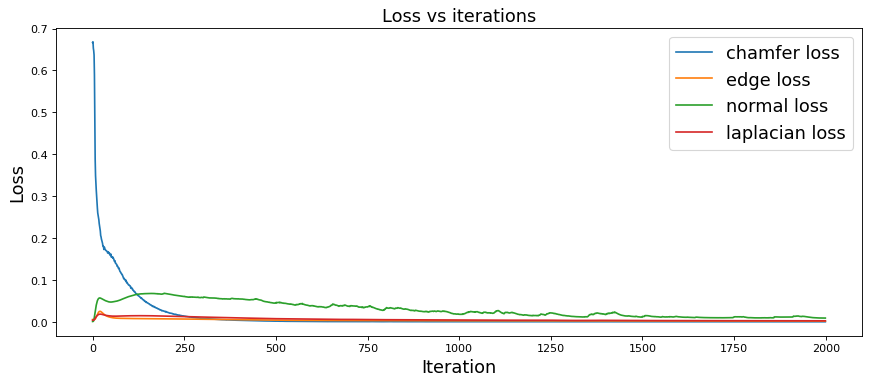

In [21]:
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16");

In [22]:

final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)


final_verts = final_verts * scale + center


final_obj = 'final_model.obj'
save_obj(final_obj, final_verts, final_faces)